In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, multivariate_normal
from anesthetic.plot import kde_plot_1d, kde_contour_plot_2d
from utils import get_limits, uniform_prior_samples
from tension_net import TensionNet
from bayes_factor import BayesFactor

In [2]:
mu0 = np.array([1, 1])
mu1 = np.array([5, 5])
Sigma0 = np.array([[1, 0], [0, 1]])
Sigma1 = np.array([[1, 0], [0, 1]])

X0 = np.random.multivariate_normal(mu0, Sigma0, size=(10000))
X1 = np.random.multivariate_normal(mu1, Sigma1, size=(10000))

X_all = torch.tensor(np.concatenate((X0, X1)))
prior_limits = get_limits(X_all)
X_prior = uniform_prior_samples(prior_limits)
X0_tensor = torch.tensor(X0, dtype=torch.float)
X1_tensor = torch.tensor(X1, dtype=torch.float)
X_prior_tensor = torch.tensor(X_prior, dtype=torch.float)

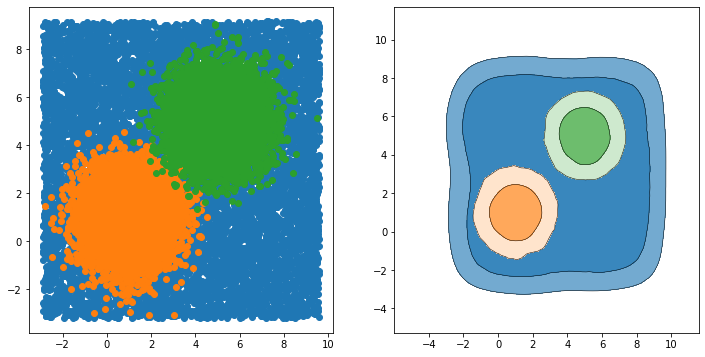

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(X_prior[:, 0], X_prior[:, 1])
axs[0].scatter(X0[:, 0], X0[:, 1])
axs[0].scatter(X1[:, 0], X1[:, 1])

kde_contour_plot_2d(axs[1], X_prior[:, 0], X_prior[:, 1])
kde_contour_plot_2d(axs[1], X0[:, 0], X0[:, 1])
kde_contour_plot_2d(axs[1], X1[:, 0], X1[:, 1])

plt.show()

## 1D Gaussian tension coordinate t

Neural network approach: let t = T(\theta; \alpha)

In [4]:
thetas = np.linspace(0, 2 * np.pi, 50)
Rs = []
for theta in thetas:
    weight = torch.tensor([[np.cos(theta), np.sin(theta)]])
    tension = TensionNet(2)
    tension.state_dict()["linear.weight"].copy_(weight)
    tension.state_dict()["linear.bias"].copy_(torch.tensor([0]))
    X0_1d = tension(X0_tensor.float())
    X1_1d = tension(X1_tensor.float())
    X_prior_1d = tension(torch.tensor(X_prior).float())

    bf = BayesFactor(1000)
    R = bf(X0_1d, X1_1d, X_prior_1d)
    Rs.append(R.item())

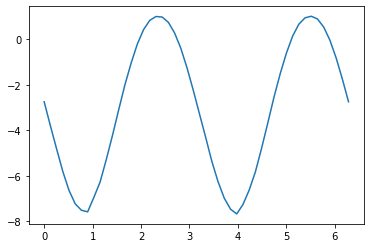

In [5]:
plt.plot(thetas, np.log(Rs))

### Try gradient descent

In [6]:
tension = TensionNet(2)
tension.state_dict()["linear.weight"].copy_(torch.tensor([[-0.3, 0.6]]))
tension.state_dict()["linear.bias"].copy_(torch.tensor([0]))
criterion = BayesFactor(1000)
optimizer = optim.SGD(tension.parameters(), lr=0.001)

losses = []
weights = torch.tensor([])
biases = torch.tensor([])
for i in range(100):
    optimizer.zero_grad()
    X0_1d = tension(X0_tensor)
    X1_1d = tension(X1_tensor)
    X_prior_1d = tension(X_prior_tensor)
    loss = torch.log(criterion(X0_1d, X1_1d, X_prior_1d))
    losses.append(loss.item())
    weights = torch.cat((weights, tension.linear.weight))
    biases = torch.cat((biases, tension.linear.bias))
    loss.backward()
    optimizer.step()

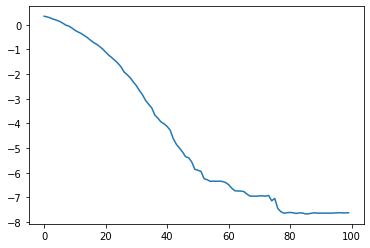

In [7]:
plt.plot(np.arange(100), losses)

In [8]:
tension.linear.weight

Parameter containing:
tensor([[0.4688, 0.5002]], requires_grad=True)

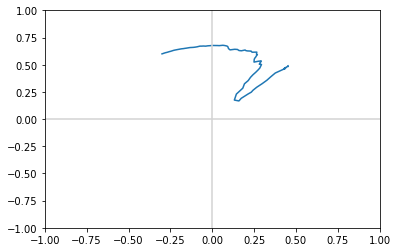

In [9]:
plt.plot(weights.detach().numpy()[:, 0], weights.detach().numpy()[:, 1])
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.axvline(0, color='lightgrey')
plt.axhline(0, color='lightgrey')

In [27]:
import torch.distributions as dists

normal = dists.Normal(torch.tensor([0]).float(), torch.tensor([1]).float())
torch.exp(normal.log_prob(torch.linspace(-2, 2, 100))).sum()

tensor(23.6771)